In [1]:
%matplotlib inline

In [2]:
import numpy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import random
import numpy as np
from scipy.cluster.vq import *
from scipy.spatial import distance
import pylab
import math
pylab.close()


In [3]:
from scipy.spatial import distance

class Data(object):
    # N points, k cluster, p dimensions
    def __init__(self, N, k, p):
        self.N = N
        self.k = k
        self.p = p
        self.true_center = []
        self.true_cluster_list = []
        self.data_set = []
        self.PIs = []
        self.means = []
        self.sigma = 0.0

    def init_board_gauss(self):
        n = float(self.N)/self.k
        X = []
        for i in range(self.k):
            c = ()
            # construct a random center point
            for j in range(self.p):
                c = c + (random.uniform(-1,1),)
            self.true_center.append(c)
            #s = random.uniform(0.05,0.5)
            s = 0.05
            x = []
            while len(x) < n:
                # need to change dimension
                lst = []
                for i in c:
                    lst.append(np.random.normal(i,s))
                point = np.array(lst)
                good = True
                for i in point:
                    if abs(i) >= 1:
                        good = False
                if good:
                    x.append(point)
            X.extend(x)
        X = np.array(X)[:self.N]
        return X

    # Taking in true center list, and the result center list
    def error_calculate(self,res):
        error = 0.0
        for i in range(self.k):
            min_dis = distance.euclidean(self.true_center[i],res[0])
            for j in range(self.k):
                # calculate the distance btw true center and kmean center
                dst = distance.euclidean(self.true_center[i],res[j])
                # find the minimum dst btw the true center and kmean center
                if dst < min_dis:
                    min_dis = dst
            error += min_dis * min_dis
        # print "the error rate is: ", error
        return math.sqrt(error / (self.sigma * self.sigma * self.p))

    # calculate the true function enables more kmean center than true center
    # this is for the true center 
    def true_cost_function(self):
        cost = 0.0
        # loop through the data set
        for data in self.data_set:
            # min_dist is the distance to the first true center
            min_dis = distance.euclidean(data,self.true_center[0])
            # loop through the true center
            for i in range(self.k):
                 # calculate the distance btw true center and kmean center
                dst = distance.euclidean(data,self.true_center[i])
                # find the minimum dst btw the true center and kmean center
                if dst < min_dis:
                    min_dis = dst
            cost += min_dis * min_dis
        return cost
    
    # this is for the cost function compared to the true center cost function
    def cost_function(self,res):
        cost = 0.0
        # loop through the whole dataset
        for data in self.data_set:
            min_dis = distance.euclidean(data,res[0])
            for i in range(self.k):
                 # calculate the distance btw true center and kmean center
                dst = distance.euclidean(data,res[i])
                # find the minimum dst btw the true center and kmean center
                if dst < min_dis:
                    min_dis = dst
            cost += min_dis * min_dis
        # the ratio of result center cost/ true center cost
        return cost/self.true_cost_function()
            

    def set_true_center(self, means):
        self.true_center = means
        
        #print "true center is ", self.true_center


    # mean is a p dimensional vector, covarience is a p*p matrix
    # number_of_sample is n samples
    # return value: n*p matrix, generate n samples from N(mean,covarience)
    def generate_mult_normal_data(self, mean, covariance, num_of_samples):
        return np.random.multivariate_normal(mean,covariance, num_of_samples)

    # prob is list of probability that sums to 1
    # means is a p dimensional vector,covarience is a p*p matrix
    # number_of_samples is n samples
    # return value: generate n samples from the mixture of Gaussian
    def generate_mult_normal_based_prob(self, prob, means, covariance, num_of_samples):
        data_list = []
        # keep track which points belong to which cluster
        true_cluster_list = []
        for i in range(num_of_samples):
            # flip a coin to see which cluster the data point comes from
            random_num = random.random()
            sum = 0.0
            index = -1
            for p in prob:
                if random_num < sum:
                    break
                sum += p
                index = index + 1
            true_cluster_list.append(index)
            # call the generate_mult_normal_data rountine
            data_list.append(self.generate_mult_normal_data(means[index], covariance,1)[0])
        self.true_cluster_list = true_cluster_list
        return np.array(data_list)[:num_of_samples]
        #return (np.array(data_list)[:num_of_samples], true_cluster_list)
    def generate_data(self, dimension, p_sigma, number_of_cluster, number_of_points):
        # dimension
        self.p = dimension

        # sqrt of variance
        self.sigma = p_sigma

        # k is number of clusters
        self.k = number_of_cluster

        # n is number of points to be generated
        self.N = number_of_points

        # init a covariance matrix as identity matrix
        self.identity_matrix = np.identity(self.p)

        # covariance matrix
        covariance = self.sigma * self.sigma * self.identity_matrix
        # choose means from


        # means are from a normal distribution with center is all 0s and varience N(0,sigma squre identity matrix)
        mean = []
        for i in range(self.p):
            mean.append(0)
        # choose means, k is the number of centers/cluster
        self.means = self.generate_mult_normal_data(mean, covariance, self.k)

        self.set_true_center(self.means)

        # choose pis, ASA probabolity
        self.PIs = []
        for i in range(self.k):
            # every cluster has the same probability
            self.PIs.append(1.0/self.k)

        # generate n points from the mixture model
        self.data_set = self.generate_mult_normal_based_prob(self.PIs, self.means, covariance, self.N)

In [4]:
def sequential_kmean(data, k):
    kmean_center = []
    idx = []
    for i in range(0, len(data)):
        idx.append(0)
    # set count n1 ... nk to 1
    counts = []
    for i in range(k):
        counts.append(1)

    # set the first seen k points to the kmean center
    for i in range(k):
        kmean_center.append(data[i])
        idx[i] = i   # remember which cluster
    kmean_center_np = np.array(kmean_center)
    index = k
    # look at the next point, and do one pass through the dataset
    while index < len(data):
        # print index
        current_point = data[index]
        min_dist =  distance.euclidean(kmean_center_np[0], current_point)
        replace_position = 0

        # find the distance to the nearest kmean center
        for i in range(k):
            dist = distance.euclidean(kmean_center_np[i], current_point)
            if dist <= min_dist:
                min_dist = dist
                replace_position = i
        # index is the current point
        idx[index] = replace_position
        index = index + 1
        # update the kmean center accordingly
        kmean_center_np[replace_position] = ((counts[replace_position] * kmean_center_np[replace_position]) + current_point) / (counts[replace_position] + 1.0)
        # update the countes -> increase the weights
        counts[replace_position] = counts[replace_position] + 1
    return np.array(kmean_center), np.array(idx)


In [5]:
#color list
color_list = ([1,0,0],[0,1,0],[0,0,1],[1,1,0],[0,1,1],[1,1,0.7],[0.7,1,0],[1,0,0.7],[0.5,0.5,0], [0.5, 0, 0.5])

#first create a dummy data object
d = Data(1000, 2, 3)
d.generate_data(2, 0.9, 3, 1000)

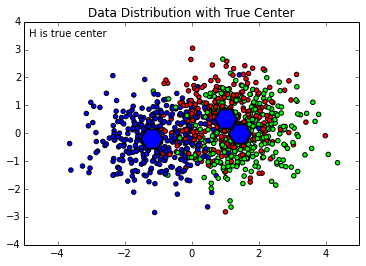

In [6]:
# true center with true cluster
colors = ([color_list[i] for i in d.true_cluster_list])
pylab.scatter(d.data_set[:,0],d.data_set[:,1], c=colors)
pylab.title("Data Distribution with True Center")
pylab.figtext(0.135,0.85,'H is true center')
# hetagon means true center
pylab.scatter(d.true_center[:,0],d.true_center[:,1], marker='H', s = 500, linewidths=2)

pylab.show()
pylab.clf()

kmean score is  0.540515389243
kmean cost function is  0.899068232944


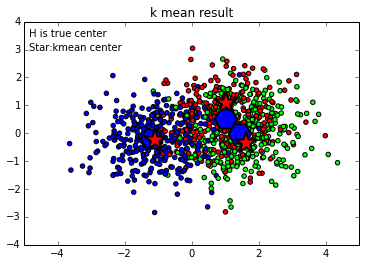

In [7]:
# expriment starts
res1, idx1 = kmeans2(d.data_set, d.k)
score = d.error_calculate(res1)
print "kmean score is ", score
print "kmean cost function is ", d.cost_function(res1)

# first graph - kmean
#colors = ([color_list[i] for i in idx1])
# color the data set distribution instead of kmean result
colors = ([color_list[i] for i in d.true_cluster_list])
pylab.title("k mean result")
pylab.scatter(d.data_set[:,0],d.data_set[:,1], c=colors)
# hetagon means true center
pylab.figtext(0.135,0.85,'H is true center')
pylab.figtext(0.135,0.8,'Star:kmean center')
pylab.scatter(d.true_center[:,0],d.true_center[:,1], marker='H', s = 500, linewidths=2)
# o means kmean center
pylab.scatter(res1[:,0],res1[:,1], marker='*', s = 500, linewidths=2, c='red')
pylab.show()
pylab.clf()

sequential kmean score is  1.48743263266
cost function is  1.63764119843


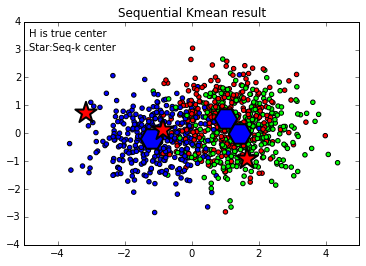

In [8]:
# run sequential kmean
res2, idx2 = sequential_kmean(d.data_set, d.k)
# take the sqrt of the entiry identity here
score = d.error_calculate(res2)
print "sequential kmean score is ", score

print "cost function is ", d.cost_function(res2)
# second graph - sequential kmean
#colors = ([color_list[i] for i in idx2])
# color the data set distribution instead of s-kmean distribution
colors = ([color_list[i] for i in d.true_cluster_list])
pylab.scatter(d.data_set[:,0],d.data_set[:,1], c=colors)
pylab.title("Sequential Kmean result")
pylab.figtext(0.135,0.85,'H is true center')
pylab.figtext(0.135,0.8,'Star:Seq-k center')
pylab.scatter(d.true_center[:,0],d.true_center[:,1], marker='H', s = 500, linewidths=2)
# x means sequential centers
pylab.scatter(res2[:,0],res2[:,1], marker='*', s = 500, linewidths=2, c='red')
pylab.show()
pylab.clf()

average score is:  0.631137182933


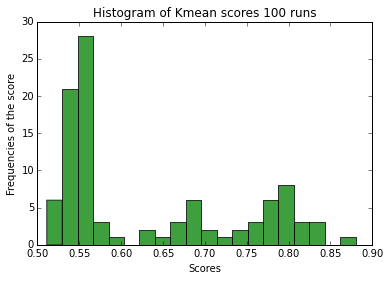

In [9]:
# Experiment 1: Running kmeans on the data and obtain average score
num_of_iterations = 100
def experiment1():
    score_list = []
    for i in range(num_of_iterations):
        res1, idx1 = kmeans2(d.data_set, d.k)
        score_list.append(d.error_calculate(res1))
    print "average score is: ", sum(score_list)/len(score_list)
    plt.xlabel('Scores')
    plt.ylabel('Frequencies of the score')
    plt.title(r'Histogram of Kmean scores 100 runs')
    #plt.bar(range(num_of_iterations), score_list)
    n, bins, patches = plt.hist(score_list,20,normed=0,facecolor="green",alpha=0.75)

    # Tweak spacing to prevent clipping of ylabel
    #plt.subplots_adjust(left=0.15)
    plt.show()
    pylab.clf()
experiment1()

sequential kmean with random permutation to the data: 
average score is:  1.46906360419


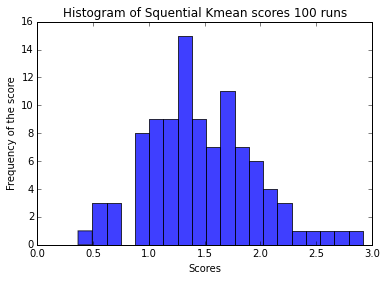

In [10]:
# Experiment 2: Running sequential kmeans on the data and obtain average score
def experiment2():
    score_list = []
    res1, idx1 = sequential_kmean(np.random.permutation(d.data_set) , d.k)
    print "sequential kmean with random permutation to the data: "
    for i in range(num_of_iterations):
        # with permutation
        res1, idx1 = sequential_kmean(np.random.permutation(d.data_set) , d.k)
        score_list.append(d.error_calculate(res1))
    print "average score is: ", sum(score_list)/len(score_list)
    # add a 'best fit' line
    plt.xlabel('Scores')
    plt.ylabel('Frequency of the score')
    plt.title(r'Histogram of Squential Kmean scores 100 runs')
    #plt.bar(range(num_of_iterations), score_list)
    # normed=0 to disable normalization, normalization makes integral of histograms sum to 1
    n, bins, patches = plt.hist(score_list,20,normed=0,facecolor="blue",alpha=0.75)

    # Tweak spacing to prevent clipping of ylabel
    #plt.subplots_adjust(left=0.15)
    plt.show()
    pylab.clf()
experiment2()

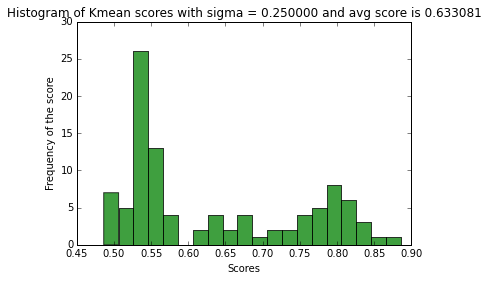

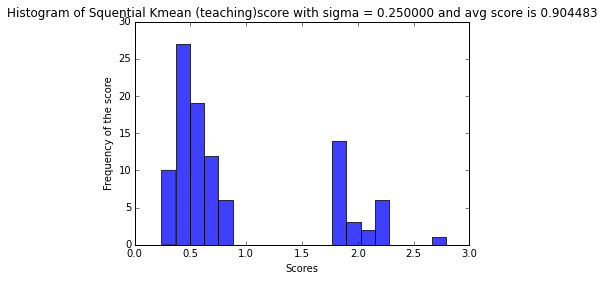

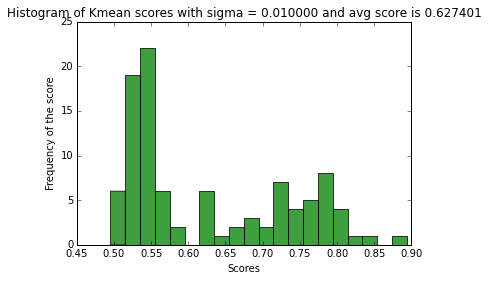

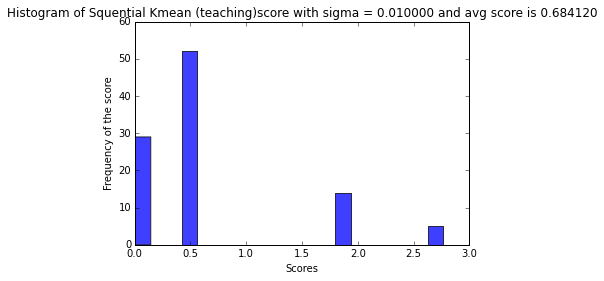

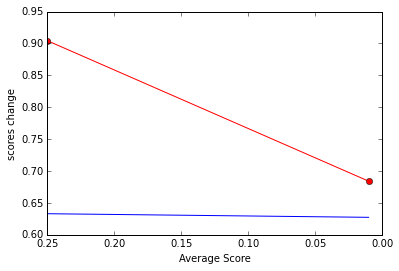

In [11]:
# Experiment 3: Adding some easy points to the list to teach the sequential kmean
# see if sequential kmean does, do the histogram compared to without teaching one
#num_of_teaching_signal = k + k/2 #this is for higher dimensional data
def experiment3():
    num_of_teaching_signal = 10 # 10 teaching signals 
    score_list_kmean = []
    score_list_skmean = []
    #sigma_list = [0.25,0.0625,0.02,0.01] # factor of 2 sigmas
    sigma_list = [0.25,0.01]
    kmean_avg_score=[]
    seq_kmean_avg_score=[]
    seq_kmean_data_avg_score=[]
    for small_sigma in sigma_list:
        score_list_kmean = []
        score_list_skmean = []
        score_list_skmean_data = []
        #give 10 easy points
        teaching_data_set = d.generate_mult_normal_based_prob(d.PIs, d.means, 
                                                          small_sigma * small_sigma * d.identity_matrix, num_of_teaching_signal)
        tmp_data_set = np.concatenate((teaching_data_set, d.data_set))

        # running the data on kmean with 20 rounds and obtain an average score
        num_of_iterations = 100
        for i in range(num_of_iterations):
            res1, idx1 = kmeans2(tmp_data_set, d.k)
            score_list_kmean.append(d.error_calculate(res1))
        avg_score = sum(score_list_kmean)/len(score_list_kmean)
        kmean_avg_score.append(avg_score)
        plt.xlabel('Scores')
        plt.ylabel('Frequency of the score')
        plt.title(r'Histogram of Kmean scores with sigma = %f and avg score is %f ' % (small_sigma, avg_score))
        #plt.text(0.75,13,'sigma = %f' % small_sigma)
        #plt.text(0.75,12,'avg score = %f ' %avg_score)
        n, bins, patches = plt.hist(score_list_kmean,20,normed=0,facecolor="green",alpha=0.75)
        plt.show()
        pylab.clf()

        # permuatate the teaching signal
        for i in range(num_of_iterations):
            # res1, idx1 = sequential_kmean(np.random.permutation(data_set) , k)
            # tmp_data_set = np.concatenate((teaching_data_set, np.random.permutation(data_set)))
            # seperately permutate teaching signal and data set
            tmp_data_set = np.concatenate((np.random.permutation(teaching_data_set), np.random.permutation(d.data_set)))
            res1, idx1 = sequential_kmean(tmp_data_set , d.k)
            score_list_skmean.append(d.error_calculate(res1))
        avg_score = sum(score_list_skmean)/len(score_list_skmean)
        seq_kmean_avg_score.append(avg_score)
        plt.xlabel('Scores')
        plt.ylabel('Frequency of the score')
        plt.title(r'Histogram of Squential Kmean (teaching)score with sigma = %f and avg score is %f ' % (small_sigma, avg_score))
        #plt.text(1,1,'sigma = %f' % small_sigma)
        #plt.text(0.8,15,'avg score = %f ' %avg_score)
        #plt.bar(range(num_of_iterations), score_list)
        n, bins, patches = plt.hist(score_list_skmean,20,normed=0,facecolor="blue",alpha=0.75)
        plt.show()
        pylab.clf()
        
#         # permutate the data set
#         for i in range(num_of_iterations):
#             # res1, idx1 = sequential_kmean(np.random.permutation(data_set) , k)
#             # tmp_data_set = np.concatenate((teaching_data_set, np.random.permutation(data_set)))
#             tmp_data_set = np.concatenate((teaching_data_set, np.random.permutation(d.data_set)))
#             res1, idx1 = sequential_kmean(tmp_data_set , d.k)
#             score_list_skmean_data.append(d.error_calculate(res1))
#         avg_score = sum(score_list_skmean)/len(score_list_skmean)
#         seq_kmean_data_avg_score.append(avg_score)
#         plt.xlabel('Scores')
#         plt.ylabel('Frequency of the score')
#         plt.title(r'Histogram of Squential Kmean(dataset) score with sigma = %f and avg score is %f ' % (small_sigma, avg_score))
#         #plt.text(1,1,'sigma = %f' % small_sigma)
#         #plt.text(0.8,15,'avg score = %f ' %avg_score)
#         #plt.bar(range(num_of_iterations), score_list)
#         n, bins, patches = plt.hist(score_list_skmean_data,20,normed=0,facecolor="blue",alpha=0.75)
#         plt.show()
#         pylab.clf()
        
    plt.plot(sigma_list,kmean_avg_score)
    plt.plot(sigma_list,seq_kmean_avg_score, marker='o',color='r')
    #plt.plot(sigma_list,seq_kmean_data_avg_score,marker = 'o',color='b')
    plt.ylabel('scores change')
    plt.xlabel('Average Score')
    # reverse the xaxis from big sigma to smaller sigma
    plt.gca().invert_xaxis()
    plt.show()
experiment3()

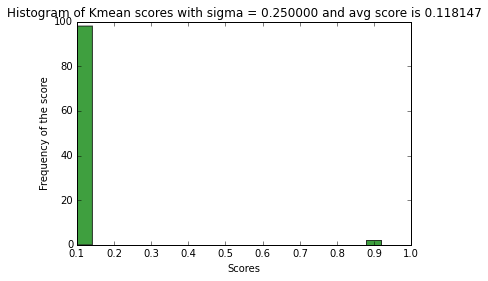

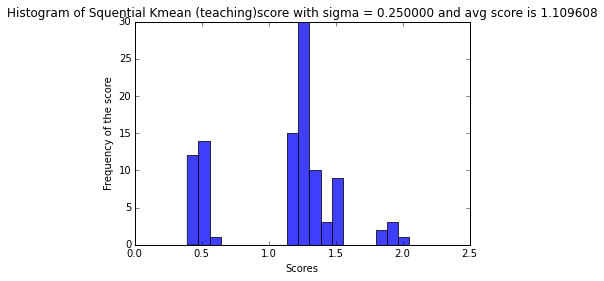

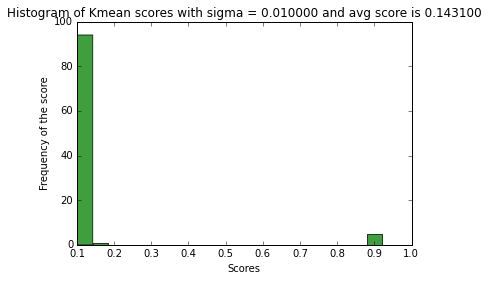

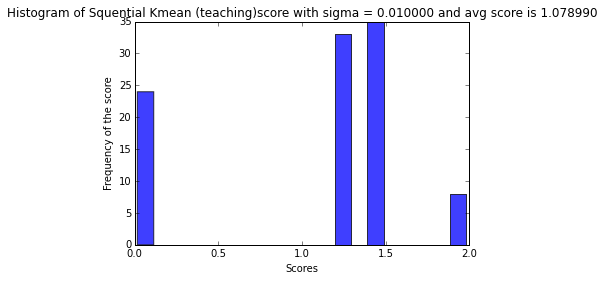

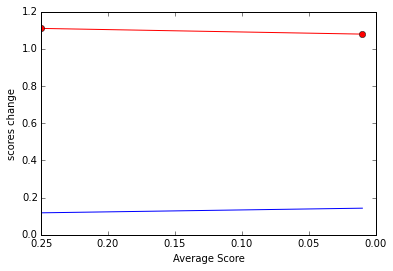

In [12]:
#generate data for dimension 10
d.generate_data(10, 0.9, 3, 1000)
experiment3()

/Users/margaretwm3/anaconda/lib/python2.7/site-packages/scipy/cluster/vq.py:600: UserWarning: One of the clusters is empty. Re-run kmean with a different initialization.
  warnings.warn("One of the clusters is empty. "


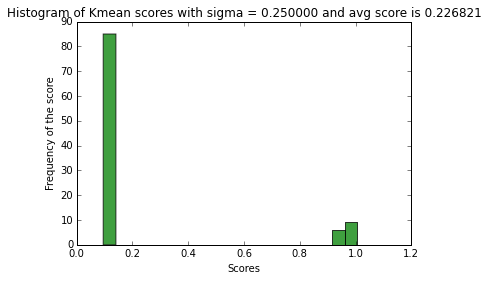

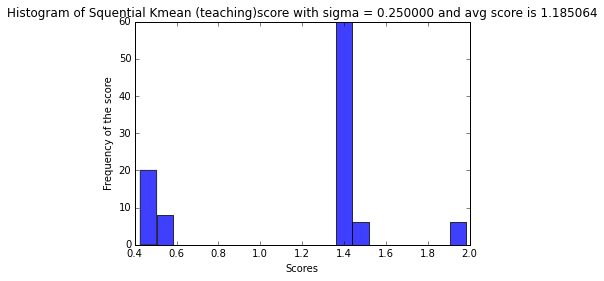

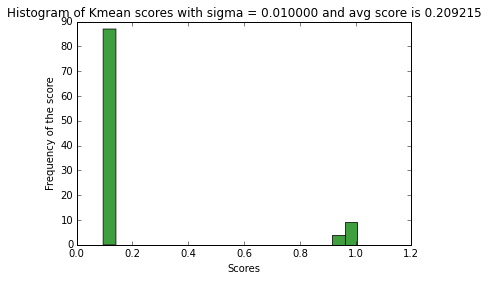

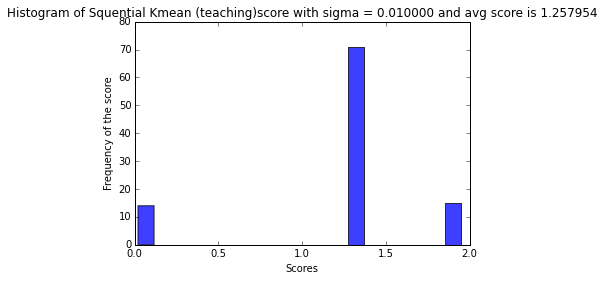

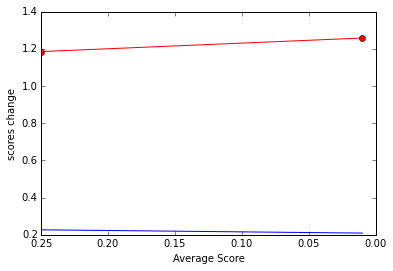

In [13]:
#generate data for dimension 100
d.generate_data(100, 0.9, 3, 1000)
experiment3()